In [1]:
from obspy import read, UTCDateTime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## ¿Qué es un archivo SEED?

Un archivo SEED (Standard for the Exchange of Earthquake Data) es un formato de archivo utilizado para almacenar y compartir datos sísmicos. 

Este formato es ampliamente utilizado por la comunidad sismológica para intercambiar información sobre eventos sísmicos, incluyendo datos de estaciones, registros de ondas sísmicas y metadatos asociados.


In [2]:
# Cargar un archivo MiniSEED
stream = read("../data/RS4D_2025-06-15.mseed")
print(stream)

5 Trace(s) in Stream:
AM.RE2AE.00.EHZ | 2025-06-15T04:16:31.761000Z - 2025-06-16T03:46:51.121000Z | 100.0 Hz, 8461937 samples
AM.RE2AE.00.ENE | 2025-06-15T04:16:31.211000Z - 2025-06-16T00:03:03.041000Z | 100.0 Hz, 7119184 samples
AM.RE2AE.00.ENE | 2025-06-16T00:03:05.111000Z - 2025-06-16T03:46:51.371000Z | 100.0 Hz, 1342627 samples
AM.RE2AE.00.ENN | 2025-06-15T04:16:31.361000Z - 2025-06-16T03:46:51.841000Z | 100.0 Hz, 8462049 samples
AM.RE2AE.00.ENZ | 2025-06-15T04:16:31.831000Z - 2025-06-16T03:46:51.321000Z | 100.0 Hz, 8461950 samples



Este archivo contiene datos de una estación sísmica **Raspberry Shake 4D**, modelo que integra:

1. **Un geófono vertical (Z)** → típicamente más sensible a frecuencias bajas.
2. **Un acelerómetro triaxial (X, Y, Z)** → mide movimiento en los tres ejes espaciales, sensible a aceleraciones más altas y abruptas.

### 📌 ¿Qué canales aparecen?

El archivo tiene múltiples trazas, cada una codificada con un identificador estándar `NET.STA.LOC.CHA`. Aquí lo que significa:

| Campo | Significado                      | Ejemplo         |
|-------|----------------------------------|-----------------|
| `NET`| Red sísmica                       | `AM` (Raspberry Shake) |
| `STA`| Nombre de la estación             | `RE2AE`         |
| `LOC`| Código de ubicación (sensor físico) | `00`          |
| `CHA`| Canal (componente del eje)        | `EHZ`, `ENN`, etc. |

### 📊 Canales presentes

| Canal                  | Eje            | Tipo de sensor   | Frecuencia | Muestras     | Duración aprox. |
|------------------------|----------------|------------------|------------|--------------|------------------|
| `AM.RE2AE.00.EHZ`      | Z              | Geófono vertical | 100 Hz     | 8,461,937    | ~1 día           |
| `AM.RE2AE.00.ENE`      | E (Este-Oeste) | Acelerómetro     | 100 Hz     | 7,119,184 + 1,342,627 | ~1 día (con corte) |
| `AM.RE2AE.00.ENN`      | N (Norte-Sur)  | Acelerómetro     | 100 Hz     | 8,462,049    | ~1 día           |
| `AM.RE2AE.00.ENZ`      | Z              | Acelerómetro     | 100 Hz     | 8,461,950    | ~1 día           |

## Construcción de la señal compuesta de magnitud de movimiento

Para facilitar la visualización del sismo y hacerlo comprensible para cualquier persona, combinaremos las tres componentes del acelerómetro (este-oeste, norte-sur y vertical) en una sola señal de **magnitud instantánea**.

Esta magnitud, denotada como $M(t)$, representa el **desplazamiento neto del suelo** en cada instante de tiempo, calculado como la norma euclidiana de los tres ejes:

$$
M(t) = \sqrt{E(t)^2 + N(t)^2 + Z(t)^2}
$$

Esto nos permite representar el sismo como si fuera una única curva que "late" con la fuerza de la tierra bajo tus pies, ideal para graficar o sincronizar con una animación.

In [ ]:
# 1. Seleccionar solo los canales acelerométricos (ENE, ENN, ENZ)
channels = ['ENE', 'ENN', 'ENZ']
traces = {ch: stream.select(channel=ch).merge(method=1)[0] for ch in channels}

# 3. Definir la hora exacta del sismo (UTC)
evento_central = UTCDateTime("2025-06-15T16:35:27")

# 4. Recorte de ±1 minuto alrededor del evento
start_time = evento_central       # 60 segundos antes
end_time = evento_central + 150    # 90 segundos después

# 5. Recortar cada traza
for ch in channels:
    traces[ch] = traces[ch].trim(starttime=start_time, endtime=end_time)

# 6. Obtener arrays numpy sincronizados
data = np.vstack([traces[ch].data for ch in channels])  # shape: (3, N)

# 7. Calcular magnitud vectorial M(t)
magnitude = np.sqrt(np.sum(data**2, axis=0))  # shape: (N,)

In [4]:
n_samples = data.shape[1]
sampling_rate = traces['ENE'].stats.sampling_rate
timestamps = np.arange(n_samples) / sampling_rate
datetime_index = pd.to_datetime(traces['ENE'].stats.starttime.datetime) + pd.to_timedelta(timestamps, unit='s')

df = pd.DataFrame({
    'datetime': datetime_index,
    'ENE': data[0],
    'ENN': data[1],
    'ENZ': data[2],
    'M': magnitude
})

In [5]:
df['magnitude_centered'] = df['M'] - df['M'].mean()

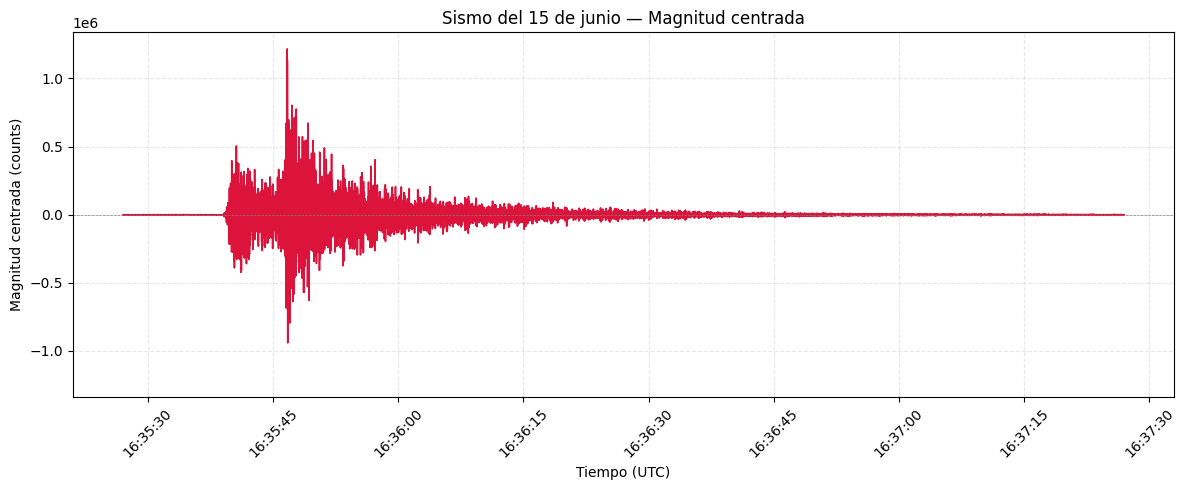

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(df['datetime'], df['magnitude_centered'], color='crimson', linewidth=1.2)

# Centrado visual
lim = abs(df['magnitude_centered']).max()
plt.ylim(-lim * 1.1, lim * 1.1)

plt.title("Sismo del 15 de junio — Magnitud centrada")
plt.xlabel("Tiempo (UTC)")
plt.ylabel("Magnitud centrada (counts)")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualización de las componentes del sismo

En esta sección graficamos las tres componentes del acelerómetro del sensor Raspberry Shake 4D correspondientes al sismo del 15 de junio de 2025:

- **ENE** (Este-Oeste)
- **ENN** (Norte-Sur)
- **ENZ** (Vertical)

Para cada componente mostramos dos gráficos:

1. **La señal en el dominio del tiempo**: permite identificar visualmente la llegada de las ondas P y S, así como su duración y atenuación.
2. **El contenido espectral (√PSD vs. período)**: muestra la energía presente en diferentes frecuencias, lo que nos ayuda a comprender las características vibracionales del evento.

Las señales han sido centradas y recortadas a una ventana de 2 minutos alrededor del evento. El espectro se calcula utilizando el método de Welch, y se presenta en una escala semilogarítmica en el eje del período (s), lo cual es común en análisis sísmico.

Esta visualización es útil tanto para el análisis científico como para la interpretación educativa del comportamiento sísmico registrado.

/var/folders/yz/81l4y8wj0dq706mv_7qpm5kw0000gn/T/ipykernel_30982/3930099106.py:27: RuntimeWarning: divide by zero encountered in divide
  period = 1 / f


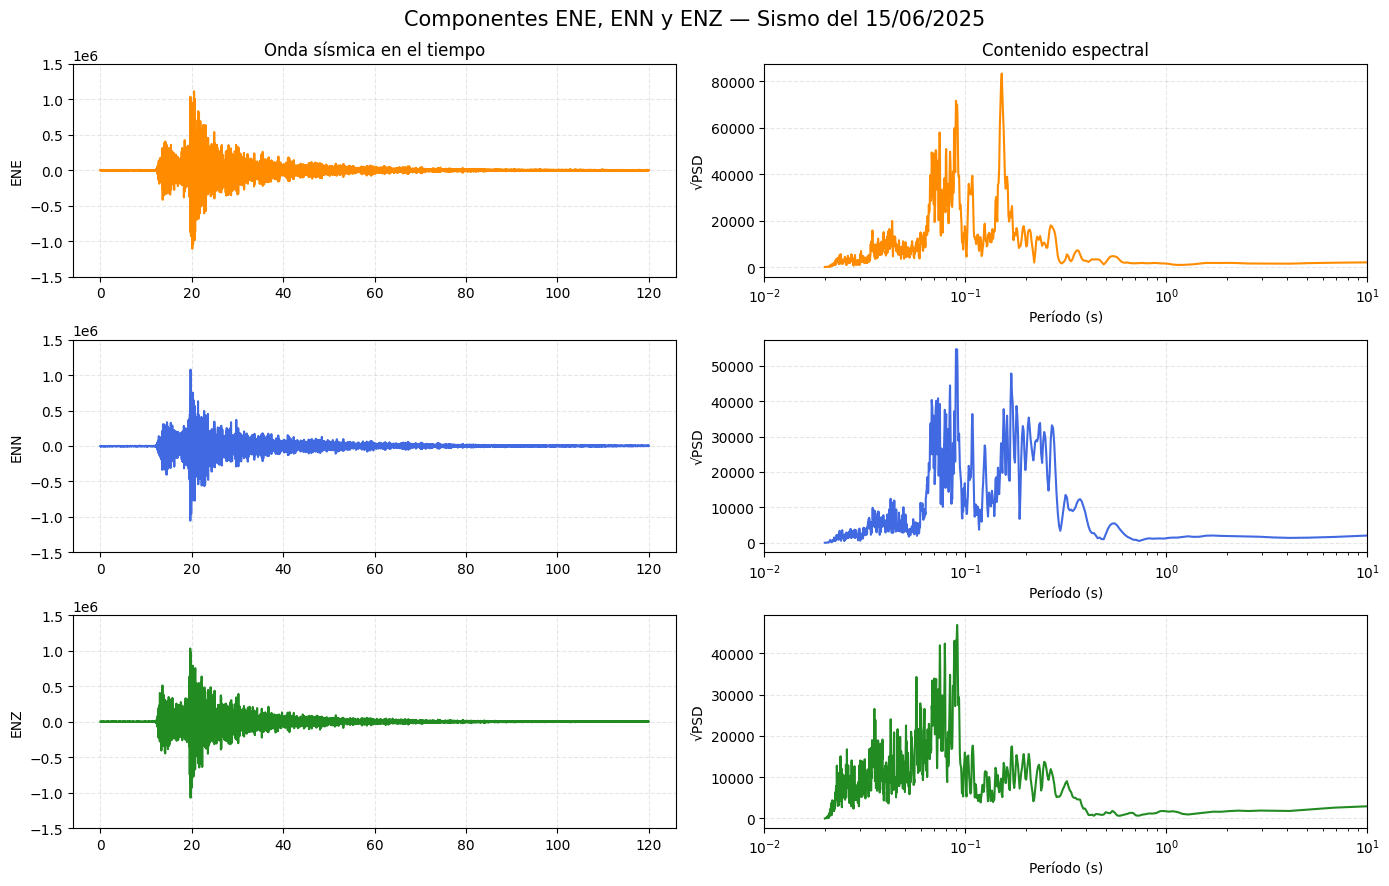

In [7]:
from scipy.signal import welch

# Ejes y colores
channels = ['ENE', 'ENN', 'ENZ']
colores = ['darkorange', 'royalblue', 'forestgreen']

# Asegúrate de tener la variable `sampling_rate`
sampling_rate = traces['ENE'].stats.sampling_rate

# Eje de tiempo
times = np.arange(data.shape[1]) / sampling_rate

# Figura
fig, axs = plt.subplots(3, 2, figsize=(14, 9))

for i, ch in enumerate(channels):
    signal = data[i] - np.mean(data[i])  # centrado en cero

    # 📈 Señal en el tiempo
    axs[i][0].plot(times, signal, color=colores[i])
    axs[i][0].set_ylabel(ch)
    axs[i][0].grid(True, linestyle='--', alpha=0.3)
    axs[i][0].set_ylim(-1.5e6, 1.5e6)

    # 📊 Espectro
    f, Pxx = welch(signal, fs=sampling_rate, nperseg=2048)
    period = 1 / f
    axs[i][1].semilogx(period, np.sqrt(Pxx), color=colores[i])
    axs[i][1].set_xlim(0.01, 10)
    axs[i][1].set_xlabel("Período (s)")
    axs[i][1].set_ylabel("√PSD")
    axs[i][1].grid(True, linestyle='--', alpha=0.3)

axs[0][0].set_title("Onda sísmica en el tiempo")
axs[0][1].set_title("Contenido espectral")
plt.suptitle("Componentes ENE, ENN y ENZ — Sismo del 15/06/2025", fontsize=15)
plt.tight_layout()
plt.show()

### Detección de la llegada de la onda P en la componente vertical (ENZ)

En este gráfico analizamos la componente vertical (ENZ) del sensor sísmico, ya que es en este eje donde suele detectarse primero la llegada de la **onda P**.

Se aplicó un centrado de la señal (restando su mediana) y luego se utilizó el método `find_peaks` para identificar los picos significativos de amplitud, utilizando un umbral basado en la desviación estándar de la señal (`1.5 * std`).

- Los puntos rojos marcan los **picos detectados**.
- La línea vertical verde indica el primer pico significativo, considerado como una **estimación de la llegada de la onda P**.

Este tipo de análisis permite estimar automáticamente el tiempo de arribo de la onda P, lo cual es crucial en estudios de propagación sísmica, alerta temprana y validación de modelos de simulación.

In [8]:
from scipy.signal import find_peaks

# Trabaja sobre una versión suavizada o centrada
signal = df['ENZ'] - df['ENZ'].median()
peaks, _ = find_peaks(np.abs(signal), height=np.std(signal)*1.5, distance=100)

# Tomamos los primeros picos reales
df_peaks = df.iloc[peaks]
print(df_peaks[['datetime', 'ENZ']].head())

                    datetime      ENZ
1359 2025-06-15 16:35:40.591  4031072
1480 2025-06-15 16:35:41.801  3134175
1616 2025-06-15 16:35:43.161  3282436
1763 2025-06-15 16:35:44.631  3797162
1866 2025-06-15 16:35:45.661  3851660


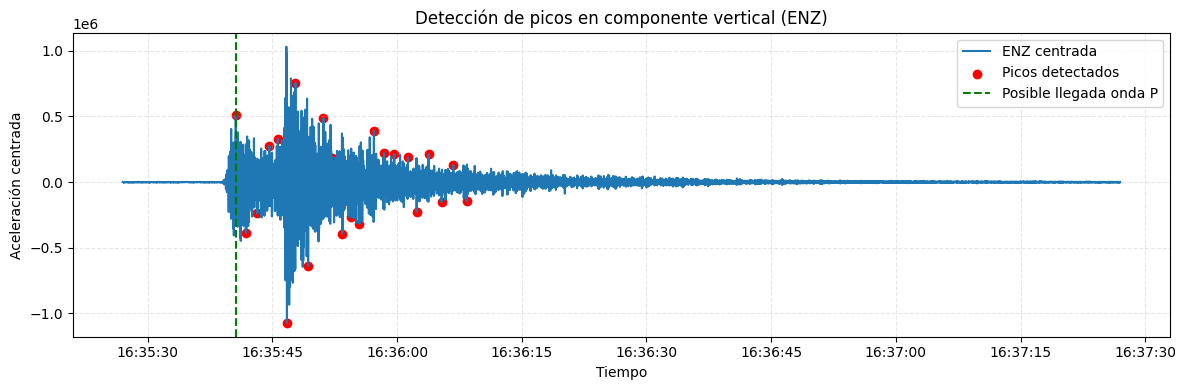

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(df['datetime'], df['ENZ'] - df['ENZ'].median(), label='ENZ centrada')
plt.scatter(df_peaks['datetime'], df_peaks['ENZ'] - df['ENZ'].median(), color='red', label='Picos detectados')
plt.axvline(df_peaks.iloc[0]['datetime'], color='green', linestyle='--', label='Posible llegada onda P')
plt.title("Detección de picos en componente vertical (ENZ)")
plt.xlabel("Tiempo")
plt.ylabel("Aceleración centrada")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import pytz

df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
df['datetime'] = df['datetime'].dt.tz_convert('America/Lima')

df['datetime'] = df['datetime'].dt.strftime("%Y-%m-%dT%H:%M:%S.%f").str[:-3]

In [11]:
df.to_csv("earthquake_data.csv", index=False)